<a href="https://colab.research.google.com/github/poppvk935/Astrophysics-Deep-Learning/blob/main/Tutorial/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import torch

In [91]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
#Transform the data
#mnist images are 2d but we need a 4d tensor, (number of images, height, width, color channel)
#Convern MNIST image files into tensor of 4 Dimensions
transform = transforms.ToTensor()

In [93]:
#Train data

train_data = datasets.MNIST(root = '/cnn_data', train = True, download = True, transform = transform)

In [94]:
#Test data
test_data = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform = transform)

In [95]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [96]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [97]:
#Create a loader for the data
  #need to create batch size, small size
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)


In [98]:
#Define CNN Model
#Describe convolutional layer and what its doing (2 conv layers)
#just an example

conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1) #6 inputs go with 6 outputs


In [99]:
#Grab 1 MNIST Record/image
for i, (X_train, y_train) in enumerate(train_data):
  break;

In [100]:
X_train.shape

torch.Size([1, 28, 28])

In [101]:
#change to 4d batch
x = X_train.view(1,1,28,28 ) #1 batch of 1 image of 28heightx28width

In [102]:
#perform first convolution
x = F.relu(conv1(x)) #relu is activation function


In [103]:
#1 single image, 6 filters/feature maps, 26x26 because we didn't set padding
x.shape

torch.Size([1, 6, 26, 26])

In [104]:
#pass through pooling layer
x = F.max_pool2d(x, 2,2) #kernel size 2, stride size 2

In [105]:
#26/2 = 13
x.shape

torch.Size([1, 6, 13, 13])

In [106]:
#Do second conv layer

x = F.relu(conv2(x))

In [107]:
x.shape

torch.Size([1, 16, 11, 11])

In [108]:
#pooling layer again

x = F.max_pool2d(x, 2, 2)

In [109]:
x.shape

torch.Size([1, 16, 5, 5])

In [110]:
#Model class
class ConvNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    #fully connected layers
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self,X):
    #First pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2,2)
    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2,2)
    #Re-view to flatten it out
    X = X.view(-1, 16*5*5) #negative so we can vary the batch size

    #Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X =(self.fc3(X))

    return F.log_softmax(X, dim = 1)

In [111]:
#Create an instance of the Model and set manual seed

torch.manual_seed(41)
model = ConvNN()
model

ConvNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [112]:
#Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #the smaller the learning rate, the longer it takes to train


In [113]:
import time
start_time = time.time()

#create variable to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


#Foor loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


#train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #start batches as 1
    y_pred = model(X_train) #get predicted values from training set
    loss = criterion(y_pred, y_train) #how off are we


    predicted = torch.max(y_pred.data, 1)[1] #add up number of correct predictions, indexed off of first point
    batch_correct = (predicted == y_train).sum() #how many we got correct from specific batch, true = 1, false = 0
    trn_corr +=batch_correct #keep track as we go along and train

  #update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  #print results
    if(b%600 == 0):
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)
#test

with torch.no_grad(): # no gradient so we dont update weights and biases
  for b,(X_test, y_test) in enumerate(test_loader):
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    tst_corr += (predicted == y_test).sum()
loss = criterion(y_val, y_test)
test_losses.append(loss)
test_correct.append(tst_corr)


current_time = time.time()

total = current_time - start_time
print(f'Training took: {total/60} minutes')


Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.06289136409759521
Epoch: 1 Batch: 1200 Loss: 0.010614877566695213
Epoch: 1 Batch: 1800 Loss: 0.03243611007928848
Epoch: 1 Batch: 2400 Loss: 0.012448625639081001
Epoch: 1 Batch: 3000 Loss: 0.000640809943433851
Epoch: 1 Batch: 3600 Loss: 0.0020938280504196882
Epoch: 1 Batch: 4200 Loss: 0.3140248656272888
Epoch: 1 Batch: 4800 Loss: 0.020231451839208603
Epoch: 1 Batch: 5400 Loss: 0.0031914091669023037
Epoch: 1 Batch: 6000 Loss: 0.0009488927898928523
Epoch: 2 Batch: 600 Loss: 0.04242878407239914
Epoc

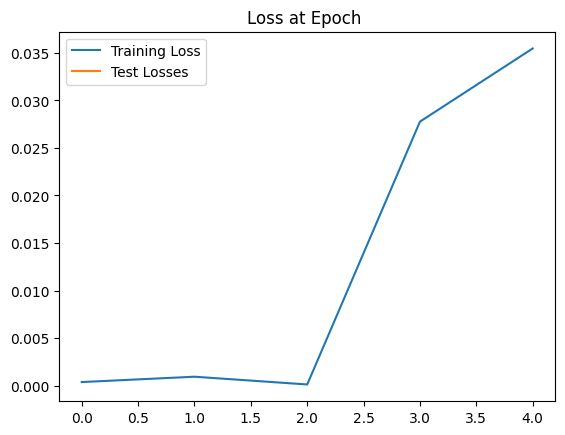

In [114]:
#graph the loss at each epoch

#convert tensors to lists first
train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label = "Test Losses")
plt.title("Loss at Epoch ")
plt.legend()

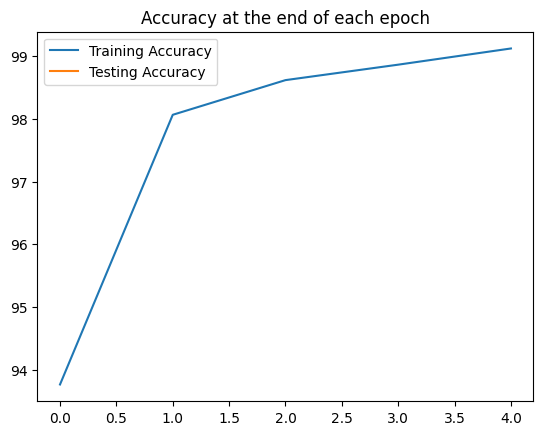

In [115]:
#Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Testing Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [116]:
test_load = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [117]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()


In [119]:
#test for correct
correct.item()/len(test_data)*100

98.25

In [122]:
#Grab an image
test_data[4143] #tensor with an image in it, end it shows the label


(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [123]:
#grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [124]:
#Reshape
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

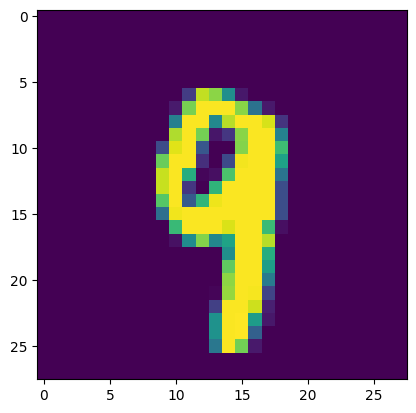

In [125]:
#Show image
plt.imshow(test_data[4143][0].reshape(28,28))

In [131]:
#pass the image through model

model.eval()
with torch.no_grad():
  new_pred= model(test_data[4143][0].view(1,1,28,28))

In [132]:
new_pred


tensor([[-1.8288e+01, -1.9011e+01, -2.1534e+01, -1.4095e+01, -6.4350e+00,
         -1.5027e+01, -2.7332e+01, -1.0378e+01, -1.3797e+01, -1.6390e-03]])

In [133]:
new_pred.argmax()

tensor(9)